In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

In [51]:
'''Computes the probability mass function from the cumulative density'''
def cdf_to_pmf(X):
    return np.concatenate(([X[0]], np.diff(X)))

def pmf_to_cdf(X):
    return X.cumsum()

'''Computes the cumulative density function of min{X,Y}'''
def cdf_min(X,Y):
    return 1 - (1-X)*(1-Y)

'''Returns the pmf of the sum of two pmfs'''
def sum_cdf(X,Y):
    X_pmf = cdf_to_pmf(X)
    Y_pmf = cdf_to_pmf(Y)
    return np.convolve(X_pmf,Y_pmf).cumsum()

def sum_pmf(X,Y):
    return np.convolve(X,Y)

'''Constructs the cdf for the shift distance t with paramter n and p'''
def shift_distance_cdf(t, n, p):
    S = binom.cdf(range(n), n-1, p)
    S = np.concatenate(([0]*t*2, S))
    return S

'''Computes the cdf of the minimum of several cdfs'''
def cdf_min_a(M):
    m = M.shape[0]
    X = M[0,:]
    for i in range(1,m):
        X = cdf_min(X, M[i,:])
    return X

'''Computes the distribution of the shift distance for strings with length n'''
def sd_cdf(n, p):
    Ks = range(n+1)
    t_max = int(np.floor(n/2))
    # start with the distribution of t=0, that is, the Hamming distance
    SD_ts = np.array([binom.cdf(Ks, n, p)])
    for t in range(1,t_max+1):
        cdf_sdt = np.pad(binom.cdf(Ks, n-t, p), [2*t,0], 'constant', constant_values=[0])[:-2*t]
        SD_ts = np.vstack([SD_ts, cdf_sdt])  
    return cdf_min_a(SD_ts)

def recursive_sd_cdf(n, p):
    if (n <= 1):
        return (np.array([1-p,1]))
    if (n == 2):
        return (np.array([(1-p)**2, 1-p*p, 1]))
    else:
        sd_n = sd_cdf(n,3/4)
        n_2 = int(np.floor(n/2))  
        cdf_n_2 = recursive_sd_cdf(n_2,p)
        cdf_rec = sum_cdf(cdf_n_2, cdf_n_2)
        cdf = cdf_min(cdf_rec, sd_n)
        return cdf

In [3]:
for k in range(11):
    n = np.power(2,k)
    Ks = np.arange(n+1)
    cdf = recursive_sd_cdf(n,3/4)
    print("{0}\t{1}".format(n, np.sum(Ks*cdf_to_pmf(cdf))/n))

1	0.75
2	0.75
4	0.6285579800605774
8	0.5890632074071046
16	0.5779675274936744
32	0.5757988102416614
64	0.5756087831446152
128	0.5756055515474376
256	0.5756055494715893
512	0.5756055494715874
1024	0.5756055494715874


In [4]:
for n in range(2,128,2):
    SD_n = sd_cdf(n,3/4)
    SD_n_2 = sd_cdf(int(n/2), 3/4)
    SD_rec = sum_cdf(SD_n_2, SD_n_2)    
    cdf = cdf_min(SD_n, SD_rec)
    tau_n = np.sum(cdf_to_pmf(cdf)*np.arange(n+1)) / n
    print("{0}\t{1}".format(n,tau_n))

2	0.59765625
4	0.6285579800605774
6	0.6413563967640235
8	0.6492428533520538
10	0.6548045320069795
12	0.6590757811532243
14	0.6625276350711388
16	0.6654157956908897
18	0.6678934773914933
20	0.6700593433088
22	0.6719804832534877
24	0.6737045393746551
26	0.6752665488746992
28	0.6766930258318314
30	0.6780045133792306
32	0.6792172477757163
34	0.6803442815115026
36	0.6813962632521762
38	0.6823819928799024
40	0.6833088251095267
42	0.6841829687046651
44	0.685009712119686
46	0.6857935962540093
48	0.6865385485186443
50	0.6872479881627158
52	0.6879249099490872
54	0.6885719513085518
56	0.6891914467373006
58	0.6897854722380143
60	0.6903558819132478
62	0.6909043383166487
64	0.691432337796962
66	0.6919412317938043
68	0.6924322448365703
70	0.6929064898400578
72	0.6933649811693736
74	0.6938086458530596
76	0.6942383332503613
78	0.6946548234212098
80	0.6950588344020817
82	0.6954510285547583
84	0.6958320181260005
86	0.6962023701327904
88	0.6965626106688209
90	0.6969132287124602
92	0.6972546795037452
94	0.

E[X] = 12.0
E[Z] = 11.035657741699676


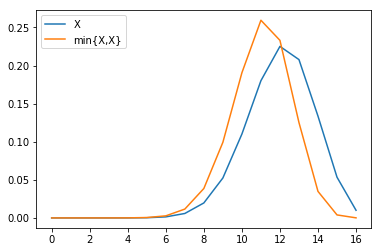

In [5]:
p = 3/4
ns = [16]
for n in ns:
    Ks = range(n+1)
    X = binom.cdf(range(n+1), n, p)
    Z = cdf_min(X,X)
    X_pmf = cdf_to_pmf(X)
    Z_pmf = cdf_to_pmf(Z)
    print("E[X] = {0}".format(np.sum(X_pmf*Ks)))
    print("E[Z] = {0}".format(np.sum(Z_pmf*Ks)))
    plt.plot(Ks, X_pmf, label='X')
    plt.plot(Ks, Z_pmf, label='min{X,X}')
    plt.legend()

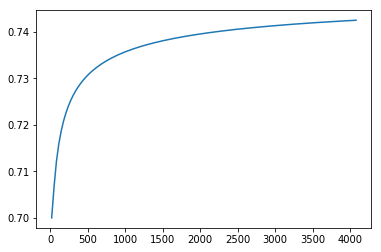

In [6]:
ns = range(16,4099,32)
As = []
for n in ns:    
    Ks = range(n+1)
    SDs = binom.cdf(Ks, n, p)
    ts = [1,2]
    for t in ts:
        St = shift_distance_cdf(t, n, p)
        St = St[:n+1]
        Z = cdf_min(St, St)
        SDs = np.vstack((SDs, Z))
        St_pmf = cdf_to_pmf(St)
        Z_pmf = cdf_to_pmf(Z)        
    SD_cdf = cdf_min_a(SDs)
    SD_pmf = cdf_to_pmf(SD_cdf)
    #print("n = {0}\n  E[SD] = {1:.2f}\n  E[X] =  {2}".format(n, np.sum(Ks*SD_pmf), n*p))
    a_n = np.sum(Ks*SD_pmf)/n
    As.append(a_n)
    #print("  alpha_n = {0}".format(a_n))
plt.plot(ns,As)

In [94]:
## Matrix of distributions
n = 8
p = 3/4
M = np.zeros([n+1,n+1,n+1])
# on celles (0,i) and (i,0) the content is deterministc
for i in range(n+1):
    M[0,i,i] = 1
    M[i,0,i] = 1
# it is convinient to have the distributions [1-p,p] and [0, 1] once for all
delta_d = np.zeros(n+1)
delta_d[0] = 1-p
delta_d[1] = p
one_d = np.zeros(n+1)
one_d[1] = 1
# M[i,j,:] represents the distribution on cell (i,j)
for i in range(1,n+1):
    for j in range(1,n+1):
        # form the distribution of the 3 cells
        diag = pmf_to_cdf(sum_pmf(M[i-1,j-1,:], delta_d)[:n+1])
        horiz = pmf_to_cdf(sum_pmf(M[i-1,j,:], one_d)[:n+1])
        vert =  pmf_to_cdf(sum_pmf(M[i,j-1,:], one_d)[:n+1])
        min_hv = cdf_min(horiz, vert)
        M[i,j,:] = cdf_to_pmf(cdf_min(diag, min_hv))
        #M[i,j,:] = cdf_to_pmf(cdf_min(M[i-1,j-1,:], diag))

In [97]:
for i in range(n+1):
    dist = M[i,i,:]
    print("{0}\t{1:.6f}".format(i, np.sum(dist*np.arange(n+1))/i))
M_Mean = np.zeros([n+1,n+1])
for i in range(n+1):
    for j in range(n+1):
        M_Mean[i,j] = np.sum(M[i,j,:]*np.arange(n+1))
M_Mean

0	nan
1	0.750000
2	0.750000
3	0.707413
4	0.662061
5	0.629208
6	0.601144
7	0.579941
8	0.561427


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0.        , 1.        , 2.        , 3.        , 4.        ,
        5.        , 6.        , 7.        , 8.        ],
       [1.        , 0.75      , 1.5625    , 2.421875  , 3.31640625,
        4.23730469, 5.17797852, 6.13348389, 7.10011292],
       [2.        , 1.5625    , 1.5       , 2.07226562, 2.78936768,
        3.61003109, 4.48246481, 5.38121949, 6.29834706],
       [3.        , 2.421875  , 2.07226562, 2.12223928, 2.55957997,
        3.19832473, 3.93089911, 4.73639327, 5.59339679],
       [4.        , 3.31640625, 2.78936768, 2.55957997, 2.64824222,
        3.03622693, 3.59473994, 4.27813905, 5.02676004],
       [5.        , 4.23730469, 3.61003109, 3.19832473, 3.03622693,
        3.14604059, 3.48679197, 4.0010041 , 4.62315248],
       [6.        , 5.17797852, 4.48246481, 3.93089911, 3.59473994,
        3.48679197, 3.60686127, 3.92975056, 4.40107866],
       [7.        , 6.13348389, 5.38121949, 4.73639327, 4.27813905,
        4.0010041 , 3.92975056, 4.05958404, 4.35955218],


In [98]:
np.savetxt("/tmp/dist_exp.txt", M_Mean, fmt="%.4f")